In [ ]:
!pip install --upgrade openai
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import openai
from openai import OpenAI
api_key= # Replace with YOUR API key!
client = OpenAI(api_key=api_key)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [ ]:
data = pd.read_csv('cc_data_seq.csv')
#data['Event'] = data['Event'].str.replace('_', '', regex=False)
data['Event'] = data['Event'].str.replace('0_0_0,', '', regex=False)
data['Event'] = data['Event'].str.replace('start,', '', regex=False)
data['Event'] = data['Event'].str.replace('end', '', regex=False)
def add_two_to_numbers(s):
    parts = s.split('_')
    if len(parts)>1:
        parts = [str(int(part) + 2) for part in parts]
        return ''.join(parts)
    else:
        return s

data['Event'] = data['Event'].apply(lambda y: ','.join([add_two_to_numbers(x) for x in y.split(',')]))
print(data.head(), len(data))

        Unnamed: 0               ID  Response  \
0  ARE000000200039  ARE000000200039         0   
1  ARE000000200051  ARE000000200051         1   
2  ARE000000300079  ARE000000300079         1   
3  ARE000000400093  ARE000000400093         1   
4  ARE000000400117  ARE000000400117         0   

                                               Event  \
0  340,444,444,444,444,444,440,440,400,000,000,00...   
1  reset,122,112,111,122,122,reset,422,reset,242,...   
2                 333,reset,223,reset,232,reset,322,   
3  322,reset,223,224,reset,232,242,142,reset,422,...   
4                           040,000,111,422,242,224,   

                                                Time  
0  0,49.3,55.9,61.7,62.6,63.2,63.5,63.9,66.4,68.4...  
1  0,98.9,151.9,156.7,160.5,164.8,165.8,166.7,170...  
2      0,113.2,119.1,122,135.4,138.5,147.8,149.8,157  
3  0,36.9,41.2,43.3,44.5,50.5,61.9,66.1,68.7,72.3...  
4  0,59.9,91.8000000000001,99.6999999999999,113.1...   16763


In [ ]:
num_train = 200 # training data size
num_val = 100   # validation data size
dat_train_val, dat_test = train_test_split(data, test_size=len(data)-(num_train + num_val), random_state=523, shuffle=True)
dat_train, dat_val = train_test_split(dat_train_val, test_size=num_val, random_state=523, shuffle=True)

training_events = set(dat_train['Event'])
# Count how many validation events are exactly in the training set
# ncount_exact_matches = dat_val['Event'].apply(lambda x: x in training_events).sum()
# print(f"Number of validation samples with events exactly in the training set: {count_exact_matches}")

len(dat_train), len(dat_val), len(dat_test)

(200, 100, 16463)

In [ ]:
def create_prompts(training_data, validation_data):
    formatted_training = ["Input: {}; Label: {}".format(event, resp) for event, resp in zip(training_data['Event'], training_data['Response'])]
    training_concatenated = " ".join(formatted_training)
    prompts = []
    labels_val = []
    for event, resp in zip(validation_data['Event'], validation_data['Response']):
        prompt = training_concatenated + " " + "Input: {}; Label: ".format(event)
        prompts.append(prompt)
        labels_val.append(resp)
    return prompts, labels_val

prompts_incontext, labels_val = create_prompts(dat_train, dat_val)
len(prompts_incontext), labels_val[0]#, prompts_incontext[0]

def create_chat_prompts(system_message, prompts_tmp):
    training_messages = []
    for prompt_i in prompts_tmp:
        prompt_one_valsample = [
            {"role": "system", "content": system_message},
            {"role": "user", "content": prompt_i}
        ]
        training_messages.append(prompt_one_valsample)
    return training_messages

system_message = "You are a helpful assistant designed to find hidden rules from the Input data to do binary classification. " \
                 "You need to first learn from the labeled data and predict the label of the last Input. " \
                 "Think it step by step but only answer 0 or 1."
prompts = create_chat_prompts(system_message, prompts_incontext)
len(prompts), prompts[0]

(100,
 [{'role': 'system',
   'content': 'You are a helpful assistant designed to find hidden rules from the Input data to do binary classification. You need to first learn from the labeled data and predict the label of the last Input. Think it step by step but only answer 0 or 1.'},
  {'role': 'user',
   'content': 'Input: 122,422,444,440,400,reset,223,232,322,reset,322,reset,reset,232,reset,223,; Label: 1 Input: ; Label: 0 Input: 434,444,422,322,422,422,422,422,422,reset,322,422,reset,242,reset,224,; Label: 1 Input: 341,444,333,000,101,322,422,022,022,032,012,014,010,011,211,311,411,311,211,; Label: 0 Input: 322,312,314,reset,322,422,reset,122,022,reset,212,202,242,reset,reset,223,224,221,220,reset,224,reset,reset,322,220,reset,220,reset,; Label: 1 Input: 322,312,311,; Label: 0 Input: 322,reset,232,242,reset,223,221,reset,; Label: 1 Input: 322,332,312,412,122,224,214,214,; Label: 0 Input: 444,; Label: 0 Input: 414,reset,022,032,034,; Label: 1 Input: 031,311,reset,212,232,242,202,rese

In [ ]:
model_name = "gpt-4"
response_list = []
token_list = []
for i, prompt_val in enumerate(prompts):
    print(f"Sample {i}:")
    response = client.chat.completions.create(
      model = model_name,
      messages = prompt_val,
      seed = 523, # the date of running this code
      temperature = 0
    )
    prediction = response.choices[0].message.content
    token_list.append(response.usage.total_tokens)
    print(prediction)
    response_list.append(prediction)

Sample 0:
0
Sample 1:
1
Sample 2:
1
Sample 3:
1
Sample 4:
0
Sample 5:
0
Sample 6:
1
Sample 7:
1
Sample 8:
0
Sample 9:
0
Sample 10:
1
Sample 11:
0
Sample 12:
1
Sample 13:
0
Sample 14:
1
Sample 15:
0
Sample 16:
1
Sample 17:
0
Sample 18:
1
Sample 19:
0
Sample 20:
0
Sample 21:
1
Sample 22:
1
Sample 23:
0
Sample 24:
1
Sample 25:
1
Sample 26:
1
Sample 27:
1
Sample 28:
1
Sample 29:
1
Sample 30:
0
Sample 31:
1
Sample 32:
1
Sample 33:
0
Sample 34:
0
Sample 35:
0
Sample 36:
1
Sample 37:
1
Sample 38:
0
Sample 39:
1
Sample 40:
0
Sample 41:
0
Sample 42:
0
Sample 43:
1
Sample 44:
1
Sample 45:
0
Sample 46:
0
Sample 47:
1
Sample 48:
1
Sample 49:
1
Sample 50:
0
Sample 51:
0
Sample 52:
1
Sample 53:
1
Sample 54:
1
Sample 55:
0
Sample 56:
1
Sample 57:
1
Sample 58:
0
Sample 59:
0
Sample 60:
1
Sample 61:
1
Sample 62:
0
Sample 63:
1
Sample 64:
1
Sample 65:
0
Sample 66:
1
Sample 67:
0
Sample 68:
0
Sample 69:
1
Sample 70:
1
Sample 71:
0
Sample 72:
1
Sample 73:
0
Sample 74:
1
Sample 75:
1
Sample 76:
1
Sample 77

In [ ]:
predictions = [int(pred) for pred in response_list]
correct_predictions = sum([1.0 for true, pred in zip(labels_val, predictions) if true == pred])
count_1 = sum(1.0 for x in labels_val if x == 1)
accuracy = correct_predictions / len(labels_val)
print("In-context (200 samples) Accuracy:", accuracy)
print("Number of samples in Class 1:", count_1)

In-context (200 samples) Accuracy: 0.78
Number of samples in Class 1: 56.0


In [ ]:
count = sum(1 for x in token_list if x > 8000)
print(count)
print(token_list)

0
[7609, 7678, 7739, 7613, 7599, 7597, 7611, 7609, 7593, 7627, 7603, 7595, 7674, 7592, 7645, 7601, 7745, 7597, 7637, 7593, 7592, 7613, 7688, 7683, 7617, 7673, 7624, 7623, 7611, 7635, 7593, 7639, 7619, 7645, 7605, 7590, 7609, 7608, 7590, 7651, 7602, 7597, 7611, 7617, 7621, 7615, 7599, 7605, 7599, 7619, 7601, 7607, 7723, 7639, 7631, 7593, 7683, 7611, 7603, 7595, 7612, 7614, 7593, 7601, 7613, 7598, 7603, 7603, 7593, 7617, 7629, 7599, 7642, 7592, 7601, 7633, 7605, 7606, 7605, 7615, 7686, 7617, 7610, 7600, 7623, 7621, 7599, 7609, 7609, 7647, 7625, 7609, 7622, 7603, 7777, 7619, 7593, 7613, 7613, 7602]


The token length should be smaller than 8192, the maximum length of gpt-4 and gpt-3.5 turbo.


# Training samples: 100

In [ ]:
dat_train_100 = dat_train.sample(n=100, random_state=523)
prompts_incontext_100, labels_val = create_prompts(dat_train_100, dat_val)
prompts_100 = create_chat_prompts(system_message, prompts_incontext_100)
model_name = "gpt-4"
response_list_100 = []
token_list_100 = []
for i, prompt_val in enumerate(prompts_100):
    print(f"Sample {i}:")
    response = client.chat.completions.create(
      model = model_name,
      messages = prompt_val,
      seed = 523, # the date of running this code
      temperature = 0
    )
    prediction = response.choices[0].message.content
    token_list_100.append(response.usage.total_tokens)
    print(prediction)
    response_list_100.append(prediction)

Sample 0:
0
Sample 1:
1
Sample 2:
1
Sample 3:
1
Sample 4:
0
Sample 5:
0
Sample 6:
1
Sample 7:
1
Sample 8:
0
Sample 9:
0
Sample 10:
1
Sample 11:
0
Sample 12:
1
Sample 13:
0
Sample 14:
1
Sample 15:
0
Sample 16:
1
Sample 17:
0
Sample 18:
1
Sample 19:
0
Sample 20:
0
Sample 21:
1
Sample 22:
1
Sample 23:
0
Sample 24:
1
Sample 25:
1
Sample 26:
1
Sample 27:
1
Sample 28:
1
Sample 29:
1
Sample 30:
0
Sample 31:
1
Sample 32:
1
Sample 33:
0
Sample 34:
1
Sample 35:
0
Sample 36:
1
Sample 37:
1
Sample 38:
0
Sample 39:
1
Sample 40:
0
Sample 41:
1
Sample 42:
0
Sample 43:
1
Sample 44:
1
Sample 45:
0
Sample 46:
0
Sample 47:
1
Sample 48:
0
Sample 49:
1
Sample 50:
0
Sample 51:
0
Sample 52:
1
Sample 53:
1
Sample 54:
1
Sample 55:
0
Sample 56:
1
Sample 57:
1
Sample 58:
0
Sample 59:
0
Sample 60:
1
Sample 61:
1
Sample 62:
0
Sample 63:
1
Sample 64:
1
Sample 65:
0
Sample 66:
1
Sample 67:
1
Sample 68:
0
Sample 69:
1
Sample 70:
1
Sample 71:
0
Sample 72:
1
Sample 73:
0
Sample 74:
1
Sample 75:
1
Sample 76:
1
Sample 77

In [ ]:
predictions = [int(pred) for pred in response_list_100]
correct_predictions = sum([1.0 for true, pred in zip(labels_val, predictions) if true == pred])
accuracy = correct_predictions / len(labels_val)
print("In-context (100 samples) Accuracy:", accuracy)

In-context (100 samples) Accuracy: 0.76


# Training samples: 50

In [ ]:
dat_train_50 = dat_train.sample(n=50, random_state=523)
prompts_incontext_50, labels_val = create_prompts(dat_train_50, dat_val)
prompts_50 = create_chat_prompts(system_message, prompts_incontext_50)
model_name = "gpt-4"
response_list_50 = []
token_list_50 = []
for i, prompt_val in enumerate(prompts_50):
    print(f"Sample {i}:")
    response = client.chat.completions.create(
      model = model_name,
      messages = prompt_val,
      seed = 523, # the date of running this code
      temperature = 0
    )
    prediction = response.choices[0].message.content
    token_list_50.append(response.usage.total_tokens)
    print(prediction)
    response_list_50.append(prediction)

Sample 0:
0
Sample 1:
1
Sample 2:
1
Sample 3:
1
Sample 4:
1
Sample 5:
0
Sample 6:
1
Sample 7:
1
Sample 8:
0
Sample 9:
0
Sample 10:
1
Sample 11:
0
Sample 12:
1
Sample 13:
0
Sample 14:
1
Sample 15:
0
Sample 16:
1
Sample 17:
1
Sample 18:
1
Sample 19:
0
Sample 20:
0
Sample 21:
1
Sample 22:
1
Sample 23:
0
Sample 24:
1
Sample 25:
1
Sample 26:
1
Sample 27:
1
Sample 28:
1
Sample 29:
1
Sample 30:
0
Sample 31:
1
Sample 32:
1
Sample 33:
0
Sample 34:
1
Sample 35:
0
Sample 36:
1
Sample 37:
1
Sample 38:
0
Sample 39:
1
Sample 40:
0
Sample 41:
1
Sample 42:
0
Sample 43:
1
Sample 44:
1
Sample 45:
0
Sample 46:
1
Sample 47:
1
Sample 48:
0
Sample 49:
1
Sample 50:
0
Sample 51:
0
Sample 52:
1
Sample 53:
1
Sample 54:
1
Sample 55:
0
Sample 56:
1
Sample 57:
1
Sample 58:
0
Sample 59:
0
Sample 60:
1
Sample 61:
1
Sample 62:
0
Sample 63:
1
Sample 64:
1
Sample 65:
1
Sample 66:
1
Sample 67:
1
Sample 68:
0
Sample 69:
1
Sample 70:
1
Sample 71:
1
Sample 72:
1
Sample 73:
0
Sample 74:
1
Sample 75:
1
Sample 76:
1
Sample 77

In [ ]:
predictions = [int(pred) for pred in response_list_50]
correct_predictions = sum([1.0 for true, pred in zip(labels_val, predictions) if true == pred])
accuracy = correct_predictions / len(labels_val)
print("In-context (50 samples) Accuracy:", accuracy)

In-context (50 samples) Accuracy: 0.73


# Training samples: 25

In [ ]:
dat_train_25 = dat_train.sample(n=25, random_state=523)
prompts_incontext_25, labels_val = create_prompts(dat_train_25, dat_val)
prompts_25 = create_chat_prompts(system_message, prompts_incontext_25)
model_name = "gpt-4"
response_list_25 = []
token_list_25 = []
for i, prompt_val in enumerate(prompts_25):
    print(f"Sample {i}:")
    response = client.chat.completions.create(
      model = model_name,
      messages = prompt_val,
      seed = 523, # the date of running this code
      temperature = 0
    )
    prediction = response.choices[0].message.content
    token_list_25.append(response.usage.total_tokens)
    print(prediction)
    response_list_25.append(prediction)

Sample 0:
0
Sample 1:
1
Sample 2:
1
Sample 3:
1
Sample 4:
0
Sample 5:
0
Sample 6:
1
Sample 7:
0
Sample 8:
0
Sample 9:
0
Sample 10:
0
Sample 11:
0
Sample 12:
0
Sample 13:
0
Sample 14:
1
Sample 15:
0
Sample 16:
1
Sample 17:
0
Sample 18:
0
Sample 19:
0
Sample 20:
0
Sample 21:
1
Sample 22:
1
Sample 23:
0
Sample 24:
0
Sample 25:
1
Sample 26:
1
Sample 27:
1
Sample 28:
1
Sample 29:
1
Sample 30:
0
Sample 31:
1
Sample 32:
1
Sample 33:
0
Sample 34:
0
Sample 35:
0
Sample 36:
0
Sample 37:
1
Sample 38:
0
Sample 39:
1
Sample 40:
0
Sample 41:
0
Sample 42:
0
Sample 43:
1
Sample 44:
1
Sample 45:
0
Sample 46:
0
Sample 47:
0
Sample 48:
0
Sample 49:
0
Sample 50:
0
Sample 51:
0
Sample 52:
1
Sample 53:
0
Sample 54:
1
Sample 55:
0
Sample 56:
1
Sample 57:
1
Sample 58:
0
Sample 59:
0
Sample 60:
1
Sample 61:
1
Sample 62:
0
Sample 63:
1
Sample 64:
1
Sample 65:
0
Sample 66:
1
Sample 67:
0
Sample 68:
0
Sample 69:
0
Sample 70:
1
Sample 71:
0
Sample 72:
1
Sample 73:
0
Sample 74:
0
Sample 75:
1
Sample 76:
1
Sample 77

In [ ]:
predictions = [int(pred) for pred in response_list_25]
correct_predictions = sum([1.0 for true, pred in zip(labels_val, predictions) if true == pred])
accuracy = correct_predictions / len(labels_val)
print("In-context (25 samples) Accuracy:", accuracy)

In-context (25 samples) Accuracy: 0.7


# 5 samples

In [ ]:
dat_train_5 = dat_train.sample(n=5, random_state=523)
prompts_incontext_5, labels_val = create_prompts(dat_train_5, dat_val)
prompts_5 = create_chat_prompts(system_message, prompts_incontext_5)
model_name = "gpt-4"
response_list_5 = []
token_list_5 = []
for i, prompt_val in enumerate(prompts_5):
    print(f"Sample {i}:")
    response = client.chat.completions.create(
      model = model_name,
      messages = prompt_val,
      seed = 523, # the date of running this code
      temperature = 0
    )
    prediction = response.choices[0].message.content
    token_list_5.append(response.usage.total_tokens)
    print(prediction)
    response_list_5.append(prediction)

Sample 0:
1
Sample 1:
1
Sample 2:
1
Sample 3:
1
Sample 4:
1
Sample 5:
1
Sample 6:
1
Sample 7:
1
Sample 8:
1
Sample 9:
0
Sample 10:
1
Sample 11:
1
Sample 12:
0
Sample 13:
0
Sample 14:
1
Sample 15:
0
Sample 16:
1
Sample 17:
1
Sample 18:
1
Sample 19:
1
Sample 20:
0
Sample 21:
1
Sample 22:
0
Sample 23:
0
Sample 24:
1
Sample 25:
1
Sample 26:
1
Sample 27:
1
Sample 28:
1
Sample 29:
1
Sample 30:
1
Sample 31:
1
Sample 32:
1
Sample 33:
0
Sample 34:
1
Sample 35:
0
Sample 36:
1
Sample 37:
1
Sample 38:
0
Sample 39:
1
Sample 40:
1
Sample 41:
1
Sample 42:
0
Sample 43:
1
Sample 44:
0
Sample 45:
1
Sample 46:
1
Sample 47:
1
Sample 48:
0
Sample 49:
1
Sample 50:
1
Sample 51:
1
Sample 52:
1
Sample 53:
1
Sample 54:
1
Sample 55:
1
Sample 56:
1
Sample 57:
1
Sample 58:
1
Sample 59:
0
Sample 60:
1
Sample 61:
1
Sample 62:
1
Sample 63:
0
Sample 64:
1
Sample 65:
1
Sample 66:
1
Sample 67:
1
Sample 68:
0
Sample 69:
1
Sample 70:
1
Sample 71:
1
Sample 72:
1
Sample 73:
0
Sample 74:
1
Sample 75:
1
Sample 76:
1
Sample 77

In [ ]:
predictions = [int(pred) for pred in response_list_5]
correct_predictions = sum([1.0 for true, pred in zip(labels_val, predictions) if true == pred])
accuracy = correct_predictions / len(labels_val)
print("In-context (25 samples) Accuracy:", accuracy)

In-context (25 samples) Accuracy: 0.62


# Save data

In [ ]:
dat_train.to_csv('dat_train.csv', index=False)
dat_val.to_csv('dat_val.csv', index=False)
labels_val_df = pd.DataFrame(labels_val, columns=['label_val'])
labels_val_df.to_csv('labels_val.csv', index=False)

# For response_list, assuming it is also a list of responses
response_list_df = pd.DataFrame(response_list, columns=['response'])
response_list_df.to_csv('response_list.csv', index=False)

# For response_list_100, assuming it is a list of responses
response_list_100_df = pd.DataFrame(response_list_100, columns=['response'])
response_list_100_df.to_csv('response_list_100.csv', index=False)

# For response_list_100, assuming it is a list of responses
response_list_50_df = pd.DataFrame(response_list_50, columns=['response'])
response_list_50_df.to_csv('response_list_50.csv', index=False)

# For response_list_100, assuming it is a list of responses
response_list_25_df = pd.DataFrame(response_list_25, columns=['response'])
response_list_25_df.to_csv('response_list_25.csv', index=False)

# For response_list_100, assuming it is a list of responses
response_list_5_df = pd.DataFrame(response_list_5, columns=['response'])
response_list_5_df.to_csv('response_list_5.csv', index=False)

# Gpt3.5 for in-context sample size=25,5

In [ ]:
dat_train_25 = dat_train.sample(n=25, random_state=523)
prompts_incontext_25, labels_val = create_prompts(dat_train_25, dat_val)
prompts_25 = create_chat_prompts(system_message, prompts_incontext_25)
model_name = "gpt-3.5-turbo"
response_list_25 = []
token_list_25 = []
for i, prompt_val in enumerate(prompts_25):
    print(f"Sample {i}:")
    response = client.chat.completions.create(
      model = model_name,
      messages = prompt_val,
      seed = 523, # the date of running this code
      temperature = 0
    )
    prediction = response.choices[0].message.content
    token_list_25.append(response.usage.total_tokens)
    print(prediction)
    response_list_25.append(prediction)

Sample 0:
1
Sample 1:
1
Sample 2:
1
Sample 3:
1
Sample 4:
1
Sample 5:
1
Sample 6:
1
Sample 7:
1
Sample 8:
1
Sample 9:
1
Sample 10:
1
Sample 11:
1
Sample 12:
1
Sample 13:
1
Sample 14:
1
Sample 15:
1
Sample 16:
1
Sample 17:
1
Sample 18:
1
Sample 19:
1
Sample 20:
1
Sample 21:
1
Sample 22:
1
Sample 23:
1
Sample 24:
1
Sample 25:
1
Sample 26:
1
Sample 27:
1
Sample 28:
1
Sample 29:
1
Sample 30:
1
Sample 31:
1
Sample 32:
1
Sample 33:
1
Sample 34:
1
Sample 35:
1
Sample 36:
1
Sample 37:
1
Sample 38:
1
Sample 39:
1
Sample 40:
1
Sample 41:
1
Sample 42:
1
Sample 43:
1
Sample 44:
1
Sample 45:
1
Sample 46:
1
Sample 47:
1
Sample 48:
1
Sample 49:
1
Sample 50:
1
Sample 51:
1
Sample 52:
1
Sample 53:
1
Sample 54:
1
Sample 55:
1
Sample 56:
0
Sample 57:
1
Sample 58:
1
Sample 59:
1
Sample 60:
1
Sample 61:
1
Sample 62:
1
Sample 63:
1
Sample 64:
1
Sample 65:
1
Sample 66:
1
Sample 67:
1
Sample 68:
1
Sample 69:
1
Sample 70:
1
Sample 71:
1
Sample 72:
1
Sample 73:
1
Sample 74:
1
Sample 75:
1
Sample 76:
1
Sample 77

In [ ]:
predictions = [int(pred) for pred in response_list_25]
correct_predictions = sum([1.0 for true, pred in zip(labels_val, predictions) if true == pred])
accuracy = correct_predictions / len(labels_val)
print("In-context (25 samples) Accuracy:", accuracy)

In-context (25 samples) Accuracy: 0.55


In [ ]:
dat_train_5 = dat_train.sample(n=5, random_state=523)
prompts_incontext_5, labels_val = create_prompts(dat_train_5, dat_val)
prompts_5 = create_chat_prompts(system_message, prompts_incontext_5)
model_name = "gpt-3.5-turbo"
response_list_5 = []
token_list_5 = []
for i, prompt_val in enumerate(prompts_5):
    print(f"Sample {i}:")
    response = client.chat.completions.create(
      model = model_name,
      messages = prompt_val,
      seed = 523, # the date of running this code
      temperature = 0
    )
    prediction = response.choices[0].message.content
    token_list_5.append(response.usage.total_tokens)
    print(prediction)
    response_list_5.append(prediction)

Sample 0:
1
Sample 1:
1
Sample 2:
1
Sample 3:
1
Sample 4:
1
Sample 5:
1
Sample 6:
1
Sample 7:
1
Sample 8:
1
Sample 9:
1
Sample 10:
1
Sample 11:
1
Sample 12:
1
Sample 13:
1
Sample 14:
1
Sample 15:
1
Sample 16:
1
Sample 17:
1
Sample 18:
1
Sample 19:
1
Sample 20:
1
Sample 21:
1
Sample 22:
1
Sample 23:
1
Sample 24:
1
Sample 25:
1
Sample 26:
1
Sample 27:
1
Sample 28:
1
Sample 29:
1
Sample 30:
1
Sample 31:
1
Sample 32:
1
Sample 33:
1
Sample 34:
1
Sample 35:
1
Sample 36:
1
Sample 37:
1
Sample 38:
1
Sample 39:
1
Sample 40:
0
Sample 41:
1
Sample 42:
1
Sample 43:
1
Sample 44:
1
Sample 45:
1
Sample 46:
1
Sample 47:
1
Sample 48:
1
Sample 49:
1
Sample 50:
1
Sample 51:
1
Sample 52:
1
Sample 53:
1
Sample 54:
1
Sample 55:
1
Sample 56:
1
Sample 57:
1
Sample 58:
1
Sample 59:
1
Sample 60:
1
Sample 61:
1
Sample 62:
1
Sample 63:
1
Sample 64:
1
Sample 65:
1
Sample 66:
1
Sample 67:
1
Sample 68:
1
Sample 69:
1
Sample 70:
1
Sample 71:
1
Sample 72:
1
Sample 73:
1
Sample 74:
1
Sample 75:
1
Sample 76:
1
Sample 77

In [ ]:
predictions = [int(pred) for pred in response_list_5]
correct_predictions = sum([1.0 for true, pred in zip(labels_val, predictions) if true == pred])
accuracy = correct_predictions / len(labels_val)
print("In-context (25 samples) Accuracy:", accuracy)

In-context (25 samples) Accuracy: 0.57


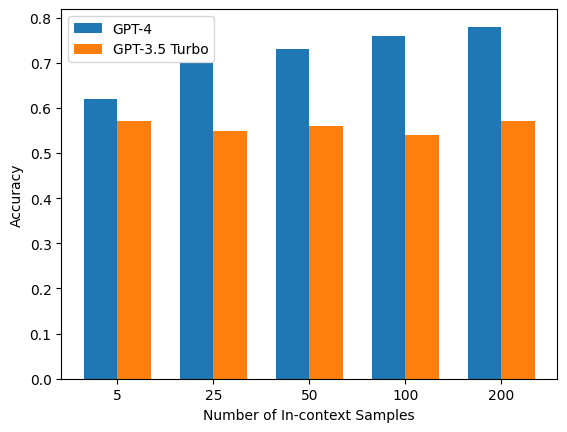

In [ ]:
data_a = [
    [200, 0.78], [100, 0.76], [50, 0.73], [25, 0.70], [5, 0.62]
]
data_a.sort()
data_b = [
    [5, 0.57], [25, 0.55], [50, 0.56], [100, 0.54], [200, 0.57]
]
data_b.sort()

in_context_samples = [x[0] for x in data_a]
accuracy_a = [x[1] for x in data_a]
accuracy_b = [x[1] for x in data_b]

x = np.arange(len(in_context_samples))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, accuracy_a, width, label='GPT-4')
rects2 = ax.bar(x + width/2, accuracy_b, width, label='GPT-3.5 Turbo')

ax.set_xlabel('Number of In-context Samples')
ax.set_ylabel('Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(in_context_samples)
ax.legend()

plt.savefig('accuracy_gpt.pdf')